In [26]:
from glob import glob
import json

import matplotlib.pyplot as plt 
import pandas as pd

In [60]:
convert_dict = {'timestamp': "datetime64[ns]", 
                'close': float,
                'volume': int,
                'daily_pct': float,
                'class': int
               } 

spy = pd.read_csv("data/performance/SPY.csv", parse_dates=True).rename(
    columns={'date': 'timestamp'})
spy['class'] = spy.daily_pct.apply(lambda x: 1 if x > 0 else 0)
spy = spy.astype(convert_dict).set_index('timestamp')

pop = pd.read_csv("merged_popularity_simple.csv", index_col='timestamp', parse_dates=True)

In [63]:
reddit_ct = {}
for x in glob("data/reddit_submissions/*.json"):
    m,d,y = x.split('/')[-1].split('.')[0].split('_')
    key = '-'.join([y,m,d])
    with open(x, 'r') as f:
        data = json.load(f)
        reddit_ct[key] = len(data['data'])
reddit_df = pd.DataFrame(data={'timestamp': reddit_ct.keys(), 'submission_ct': reddit_ct.values()})
convert_dict = {'timestamp': "datetime64[ns]", 
                'submission_ct': float
               } 
  
reddit_df = reddit_df.astype(convert_dict)
reddit_df = reddit_df.set_index('timestamp')


In [64]:
daily_pc = reddit_df.submission_ct/reddit_df.submission_ct.shift(1) - 1
reddit_df['pct_change'] = daily_pc

daily_pc = pop["sum"]/pop["sum"].shift(1) - 1
pop['pct_change'] = daily_pc

In [65]:
test = pd.merge(reddit_df, pop, on='timestamp', how='outer').dropna()
test = pd.merge(test, spy, on='timestamp', how='outer').dropna()
print(test.head())
print(len(test))

            submission_ct  pct_change_x         sum  pct_change_y   close  \
timestamp                                                                   
2019-08-20          365.0     -0.641454  25359286.0      0.001336  290.09   
2019-09-26          220.0     -0.397260  26014370.0      0.001088  297.00   
2020-03-11         3207.0      7.395288  36243480.0      0.009622  274.36   
2018-12-11          287.0     -0.910508  16754002.0      0.000650  264.13   
2018-07-24          597.0      1.080139  12908948.0      0.001772  281.61   

                 volume  daily_pct  class  
timestamp                                  
2019-08-20   51652752.0  -0.007663    0.0  
2019-09-26   58722357.0  -0.002083    0.0  
2020-03-11  256416563.0  -0.048748    0.0  
2018-12-11  121504431.0   0.000227    1.0  
2018-07-24   68026935.0   0.005032    1.0  
563


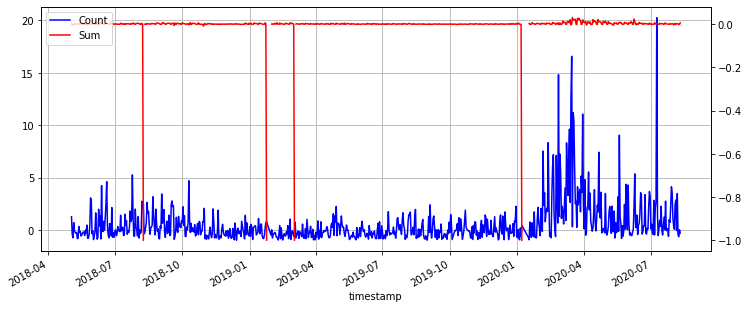

In [27]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of requests every 10 minutes')

ax1 = test.pct_change_x.plot(color='blue', grid=True, label='Count')
ax2 = test.pct_change_y.plot(color='red', grid=True, secondary_y=True, label='Sum')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [58]:
import statsmodels.api as sm

X = test["submission_ct"]
y = test["sum"]

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    sum   R-squared (uncentered):                   0.336
Model:                            OLS   Adj. R-squared (uncentered):              0.335
Method:                 Least Squares   F-statistic:                              420.1
Date:                Thu, 22 Oct 2020   Prob (F-statistic):                    7.10e-76
Time:                        00:06:41   Log-Likelihood:                         -15462.
No. Observations:                 832   AIC:                                  3.093e+04
Df Residuals:                     831   BIC:                                  3.093e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
submission_ct  3.582e+04   1747.450     20.496      0.000    3.24e+04    3.92e+04
==============================================================================
Omnibus:                       46.957   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.021
Skew:                           0.257   Prob(JB):                     7.11e-28
Kurtosis:                       4.828   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
test.to_csv('tester_ct.csv')